TODO:

- Some more maths for block solvers
- drop braess-sarazin
- explain patch more

# Programming your solver

In this notebook, we will look at some of the more advanced capabilities Firedrake has for configuring and developing preconditioners. In particular, we will show support for geometric multigrid, as well as user-defined preconditioners.

As our prototypical example, we will consider the Stokes equations. Find $(u, p) \in V \times Q \subset (H^1)^d \times L^2$ such that

$$
\begin{align}
  \nu\int_\Omega \nabla u : \nabla v\,\mathrm{d}x - \int_\Omega p
  \nabla \cdot v\,\mathrm{d}x
  &= \int_\Omega f \cdot v\,\mathrm{d}x, \\
  -\int_\Omega \nabla \cdot u q \,\mathrm{d}x&= 0.
\end{align}
$$
for all $(v, q) \in V \times Q$. Where $\nu$ is the viscosity.

We will solve a regularised lid-driven cavity problem, and thus choose $f = 0$ and the boundary conditions:
$$
\begin{align}
u &= \begin{pmatrix}\frac{x^2 (2 - x)^2 y^2}{4} \\ 0 \end{pmatrix} & \text{ on $\Gamma_1 = \{y = 1\}$}\\
u &= 0 & \text{ otherwise}\\
\nabla p \cdot n &= 0 & \text{ on $\Gamma = \partial\Omega$}
\end{align}
$$

In [1]:
from firedrake import *
mesh = UnitSquareMesh(8, 8)

# Regular refinement of the given mesh
meshes = MeshHierarchy(mesh, refinement_levels=3)

# Grab the finest mesh
mesh = meshes[-1]
V = VectorFunctionSpace(mesh, "CG", 2)
Q = FunctionSpace(mesh, "CG", 1)
W = V*Q

We set up the problem in residual form (using `TestFunction`s but no `TrialFunction`s)

In [3]:
v, q = TestFunctions(W)
w = Function(W)
u, p = split(w)

nu = Constant(0.0001)
F = nu*inner(grad(u), grad(v))*dx - p*div(v)*dx - div(u)*q*dx

## Split here
x, y = SpatialCoordinate(mesh)
forcing = as_vector([0.25 * x**2 * (2-x)**2 *y**2, 0])

bcs = [DirichletBC(W.sub(0), forcing, 4),
       DirichletBC(W.sub(0), zero(mesh.geometric_dimension()), (1, 2, 3))]

# We're going to tell the solver to remove the constant pressure null mode
nullspace = MixedVectorSpaceBasis(W, [W.sub(0), VectorSpaceBasis(constant=True)])

We'll be exploring lots of different solver options, we'll write a function that builds a solver object

In [4]:
def create_solver(solver_parameters, *, pmat=None, appctx=None):
    p = {}
    if solver_parameters is not None:
        p.update(solver_parameters)
    # Default to linear SNES
    p.setdefault("snes_type", "ksponly")
    p.setdefault("ksp_rtol", 1e-7)
    problem = NonlinearVariationalProblem(F, w, bcs=bcs, Jp=pmat)
    solver = NonlinearVariationalSolver(problem, nullspace=nullspace, options_prefix="", 
                                        solver_parameters=p, appctx=appctx)
    return solver

Now let's go ahead and solve the problem using a direct solver

In [5]:
solver_parameters = {
    # Build an AIJ matrix
    "mat_type": "aij",
    "ksp_type": "preonly",
    # Use MUMPS since it handles the null space
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps"
}

In [6]:
def convergence(snes):
    from firedrake.solving_utils import KSPReasons, SNESReasons
    print("""
SNES iterations: {snes}; SNES converged reason: {snesreason}
   KSP iterations: {ksp}; KSP converged reason: {kspreason}""".format(snes=snes.getIterationNumber(),
                                                                      snesreason=SNESReasons[snes.getConvergedReason()],
                                                                      ksp=snes.ksp.getIterationNumber(),
                                                                      kspreason=KSPReasons[snes.ksp.getConvergedReason()]))

In [7]:
w.assign(0)
solver = create_solver(solver_parameters)
solver.solve()
convergence(solver.snes)


SNES iterations: 1; SNES converged reason: CONVERGED_ITS
   KSP iterations: 1; KSP converged reason: CONVERGED_ITS


We can now have a look at the solution, using some simple builtin plotting that utilises matplotlib. For any more complicated visualisation, save the data to a VTU file and inspect it using something like Paraview or Visit.

<IPython.core.display.Javascript object>


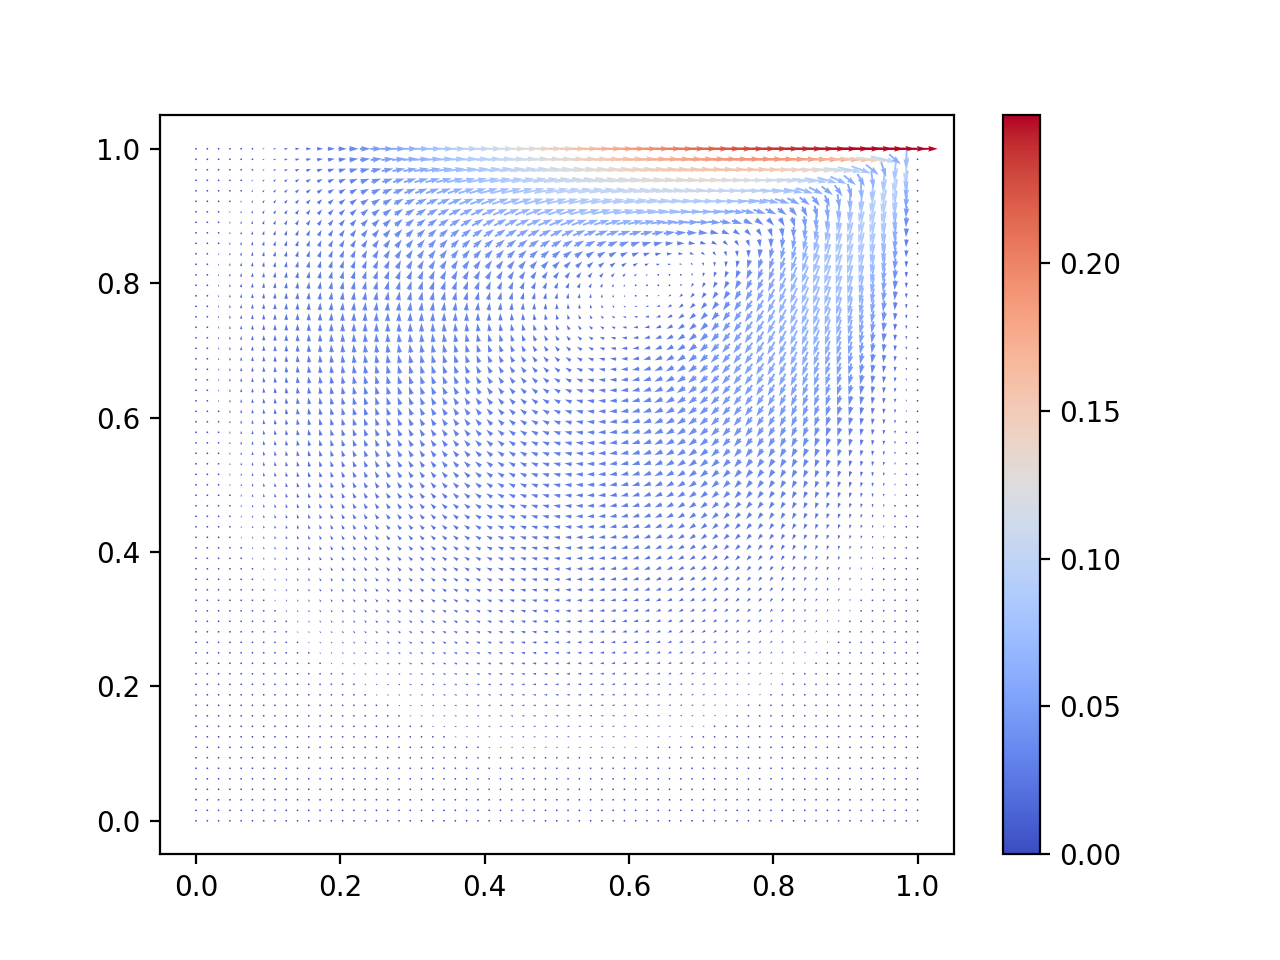

In [8]:
%matplotlib notebook
u_h, p_h = w.split()
plot(u_h);

## Configuring a better preconditioner

For this small problem, we can (and probably should) use a direct factorisation method. But what if the problem is too big? Then we need an iterative method, and an appropriate preconditioner.

Let's try everyone's favourite, ILU(0).

In [9]:
solver_parameters = {
    "mat_type": "aij",
    "ksp_type": "gmres",
    "ksp_gmres_modifiedgramschmidt": None,
    "ksp_max_it": 2000,
    "ksp_monitor": None,
    "pc_type": "ilu"
}

In [10]:
w.assign(0)
solver = create_solver(solver_parameters)
solver.solve()
convergence(solver.snes)


SNES iterations: 1; SNES converged reason: CONVERGED_ITS
   KSP iterations: 1618; KSP converged reason: CONVERGED_RTOL


This is, unsurprisingly, bad. Fortunately, better options are available.

### Block preconditioning

Firedrake hooks up all the necessary machinery to access PETSc's `PCFIELDSPLIT` preconditioner. We just have to pass appropriate options:

Add block factorisation maths here.

In [11]:
fieldsplit_parameters = {
    "mat_type": "nest",
    "ksp_type": "fgmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "schur",
    "fieldsplit_0": {
        "ksp_type": "preonly",
        "pc_type": "lu",
    },
    "fieldsplit_1": {
        "ksp_type": "cg",
        "pc_type": "none",
    }
}

In [12]:
w.assign(0)
solver = create_solver(fieldsplit_parameters)
solver.solve()
convergence(solver.snes)


SNES iterations: 1; SNES converged reason: CONVERGED_ITS
   KSP iterations: 2; KSP converged reason: CONVERGED_RTOL


This looks OK, but we want to provide a preconditioning matrix for the Schur complement. For the Stokes equations, Silvester and Wathen (1994) show that $S \approx \nu^{-1} Q$ is a good approximation, where $Q$ is the pressure mass matrix.

How do we get this matrix into the preconditioner?

XXX: Explain we provide Amat for _full_ problem and Pmat for _full_ problem: and then we're only going to use a bit of pmat.

Mimicing PETSc, we can supply a second operator to the solver, which the KSP will use to build the preconditioning matrix. This is easy to create, since it's just another variational form, and can be obtained by replacing the solution 

XXX: Use derivative.

In [14]:
w_t = TrialFunction(W)
_, p_t = split(w_t)

pmat = lhs(derivative(F, w, w_t)) + 1/nu * p_t * q*dx
#pmat = lhs(replace(F, {w: w_t})) + 1/nu * p_t * q*dx

We can now pass this pmat form to `create_solver` and can configure an appropriate preconditioner.

In [15]:
pmat_parameters = {
    "mat_type": "nest", # We only need the blocks
    "snes_type": "ksponly",
    "ksp_view": True,
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "schur",
    "fieldsplit_0": {
        "ksp_type": "preonly",
        "pc_type": "lu",
    },
    "fieldsplit_1": {
        "ksp_type": "preonly",
        "pc_type": "lu",
    }
}

In [16]:
w.assign(0)
solver = create_solver(pmat_parameters, pmat=pmat)
solver.solve()
convergence(solver.snes)


SNES iterations: 1; SNES converged reason: CONVERGED_ITS
   KSP iterations: 18; KSP converged reason: CONVERGED_RTOL


This works pretty well, taking only 18 outer iterations. We can also replace the inner solvers with approximate versions. We will do this momentarily.

### Providing auxiliary operators
One thing that is somewhat inconvenient is that we have to build a whole new operator just to get the pressure mass matrix in to the inner preconditioner. The approach adopted in Firedrake to avoid this is to piggyback on PETSc's (and petsc4py's) support for user-defined preconditioner objects. We can define a preconditioner as a Python class, and as long as it provides certain methods, it can be used as a preconditioner by PETSc. 

TOO MUCH TEXT

To simplify the problem of which methods you need to remember to implement, Firedrake offers some builtin Python preconditioners, along with an abstract base class to inherit from `PCBase`. One thing that is slightly tricky is figuring out how to get all the necessary information to construct things. For our use case, Firedrake offers a further abstraction.

Since needing to assemble an auxiliary operator of some kind is so common, we can inherit from the builtin `AuxiliaryOperatorPC` and implement the `form` method. This receives test and trial functions on the correct space and should return a form and any boundary conditions (or `None`). When it is constructed and setup, the specified operator is assembled and supplied to an algebraic preconditioner. Let's have a go:

In [17]:
class MassMatrix(AuxiliaryOperatorPC):
    # The default prefix is "aux_"
    _prefix = "mass_"
    def form(self, pc, test, trial):
        # Grab the definition of nu from the user application context (a dict)
        nu = self.get_appctx(pc)["nu"]
        return (1/nu * test*trial*dx, None)

In [18]:
mass_parameters = {
    "mat_type": "nest", # We only need the blocks
    "ksp_view": None,
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "schur",
    "fieldsplit_0": {
        "ksp_type": "preonly",
        "pc_type": "lu",
    },
    "fieldsplit_1": {
        "ksp_type": "preonly",
        "pc_type": "python",
        "pc_python_type": "__main__.MassMatrix",
        "mass_pc_type": "lu",
    }
}

In [19]:
appctx = {"nu": nu} # arbitrary user data that is available inside the user PC object
w.assign(0)
solver = create_solver(mass_parameters, appctx=appctx)
solver.solve()
convergence(solver.snes)


SNES iterations: 1; SNES converged reason: CONVERGED_ITS
   KSP iterations: 18; KSP converged reason: CONVERGED_RTOL


## Multigrid preconditioners and smoothers

In the same way that Firedrake hooks up solvers such that `PCFIELDSPLIT` is enabled, if a problem was defined on a mesh from a `MeshHierarchy`, `PCMG` and `SNESFAS` are also available. One option is to use the block preconditioning and replace the LU for the elliptic (1, 1) block with MG

In [20]:
fieldsplit_mg_parameters = {
    "mat_type": "nest",
    "ksp_view": None,
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "schur",
    "fieldsplit_0": {
        "ksp_type": "preonly",
        "pc_type": "mg",
        "mg_levels": {
            "ksp_type": "chebyshev",
            "ksp_max_it": 2,
        }
    },
    "fieldsplit_1": {
        "ksp_type": "preonly",
        "pc_type": "python",
        "pc_python_type": "__main__.MassMatrix",
        "mass_pc_type": "lu",
    }
}

In [21]:
appctx = {"nu": nu} # arbitrary user data that is available inside the user PC object
w.assign(0)
solver = create_solver(fieldsplit_mg_parameters, appctx=appctx)
solver.solve()
convergence(solver.snes)


SNES iterations: 1; SNES converged reason: CONVERGED_ITS
   KSP iterations: 33; KSP converged reason: CONVERGED_RTOL


We can also do monolithic, or "all at once" multigrid. For example, Braess-Sarazin smoothing, using global `PCFIELDSPLIT` "smoothers" on each level:

In [22]:
braess_sarazin_parameters = {
    "mat_type": "aij",
    "ksp_type": "fgmres",
    "ksp_view": None,
    "ksp_monitor": None,
    "pc_type": "mg",
    "mg_levels": {
        "ksp_type": "gmres",
        "ksp_max_it": 2,
        "pc_type": "fieldsplit",
        "fieldsplit_0": {
            "ksp_type": "preonly",
            "pc_type": "ilu",
        },
        "fieldsplit_1": {
            "ksp_type": "preonly",
            "pc_type": "python",
            # Notice how we can easily put the right mass matrix in
            # here.
            "pc_python_type": "__main__.MassMatrix",
            "mass_pc_type": "ilu",
        }
    },
    "mg_coarse": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    }
}

In [23]:
appctx = {"nu": nu} # arbitrary user data that is available inside the user PC object
w.assign(0)
solver = create_solver(braess_sarazin_parameters, appctx=appctx)
solver.solve()
convergence(solver.snes)


SNES iterations: 1; SNES converged reason: CONVERGED_ITS
   KSP iterations: 44; KSP converged reason: CONVERGED_RTOL


Another option is to do Vanka smoothing, which is supported by PETSc's (new) `PCPATCH` preconditioner. This is supported in Firedrake too with a builtin `PatchPC` object which sets everything up.

In [24]:
vanka_parameters = {
    "mat_type": "matfree", # We only need the action
    "ksp_type": "fgmres",
    "ksp_view": None,
    "ksp_monitor": None,
    "pc_type": "mg",
    "mg_levels": {
        "ksp_type": "chebyshev",
        "ksp_convergence_test": "skip",
        "ksp_max_it": 2,
        "pc_type": "python",
        "pc_python_type": "firedrake.PatchPC",
        "patch": {
            "pc_patch_save_operators": 1,
            "pc_patch_partition_of_unity": False,
            "pc_patch_construct_dim": 0,
            # Topological decomposition
            "pc_patch_construct_type": "vanka",
            # Pressure space is constraint space
            "pc_patch_exclude_subspaces": 1,
            # Configure the solver on each patch
            "pc_patch_sub": {
                "mat_type": "dense",
                "ksp_type": "preonly",
                "pc_type": "lu",
                "pc_factor_shift_type": "nonzero",
            }
        }
    },
    "mg_coarse": {
        "ksp_type": "preonly",
        "pc_type": "python",
        "pc_python_type": "firedrake.AssembledPC",
        "assembled": {
            "pc_type": "lu",
            "pc_factor_mat_solver_type": "mumps",
        }
    }
}

In [25]:
w.assign(0)
solver = create_solver(vanka_parameters)
solver.solve()
convergence(solver.snes)


SNES iterations: 1; SNES converged reason: CONVERGED_ITS
   KSP iterations: 12; KSP converged reason: CONVERGED_RTOL
